In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import sys

sys.path.insert(0,'/home/sunnycui/deepcell-tf/') 

### Read Tiff files into npz

In [2]:
from skimage.external.tifffile import TiffFile
from skimage.io import imread, imread_collection, ImageCollection
from skimage import io
io.use_plugin('matplotlib', 'imread')


def get_image(file_name):
    """Read image from file and returns it as a tensor
    Function from deepcell.utils

    Args:
        file_name: path to image file

    Returns:
        numpy array of image data
    """
    ext = os.path.splitext(file_name.lower())[-1]
    if ext == '.tif' or ext == '.tiff':
        return np.float32(TiffFile(file_name).asarray())
    return np.float32(imread(file_name))

def get_collection(file_name):
    collection = ImageCollection(file_name)
    image_stack = np.stack([img for img in collection])
    return image_stack
        
        
    
DATA_DIR = os.path.join(sys.path[0], 'scripts/recurr_gru/data/')

file_dict = dict()

for y_file in os.listdir(os.path.join(DATA_DIR, 'sparse/DAPI_sparse')):
    # print("file: ", y_file)
    X_file = y_file.replace("_Dapii", "")
    # print("X_file: ", X_file)
    file_dict[X_file] = y_file

# print(file_dict)

X = []
y = []

for key, val in file_dict.items():
    print("processing: ", key)
    X_path = os.path.join(DATA_DIR, 'sparse/z_stacks_phase_sparse', key)
    X.append(get_collection(X_path))
    y_path = os.path.join(DATA_DIR, 'sparse/DAPI_sparse', val)
    y.append(get_image(y_path))

processing:  20190429_RAW264_F03_0001.tif
processing:  20190429_RAW264_H03_0001.tif
processing:  20190429_RAW264_G03_0008.tif
processing:  20190429_RAW264_F02_0004.tif
processing:  20190429_RAW264_G05_0024.tif
processing:  20190429_RAW264_H03_0002.tif
processing:  20190429_RAW264_F04_0002.tif
processing:  20190429_RAW264_F05_0018.tif
processing:  20190429_RAW264_H02_0020.tif
processing:  20190429_RAW264_F05_0006.tif
processing:  20190429_RAW264_H02_0017.tif
processing:  20190429_RAW264_H05_0000.tif
processing:  20190429_RAW264_G02_0009.tif
processing:  20190429_RAW264_F05_0023.tif
processing:  20190429_RAW264_G03_0009.tif
processing:  20190429_RAW264_H05_0014.tif
processing:  20190429_RAW264_H02_0024.tif
processing:  20190429_RAW264_F05_0014.tif
processing:  20190429_RAW264_H02_0016.tif
processing:  20190429_RAW264_F02_0000.tif
processing:  20190429_RAW264_F02_0016.tif
processing:  20190429_RAW264_G05_0001.tif
processing:  20190429_RAW264_H05_0013.tif
processing:  20190429_RAW264_G04_0

In [3]:
n = int(len(y)/2)
X2 = np.stack(X[:n])
y2 = np.stack(y[:n])
print("X2.shape, y1.shape", X2.shape, y2.shape)


# Define a normalizaiton function for the raw images that can be run before padding
def image_norm(original_image):
    # NNs prefer input data that is 0 mean and unit variance
    normed_image = (original_image - np.mean(original_image)) / np.std(original_image)
    return normed_image

DATA_DIR = os.path.join(sys.path[0], 'scripts/recurr_gru/data/')

# for i in range(len(y2)):
#     y2[i] = image_norm(y2[i])
#     for j in range(len(X2)):
#         X2[i, j, :, :] = image_norm(X2[i, j, :, :])

file_name_save = os.path.join(DATA_DIR, 'dapi_full_1.npz')
np.savez(file_name_save, X=X2, y=y2)

X2.shape, y1.shape (42, 61, 1608, 1608) (42, 1608, 1608)


### Test plot images

In [ ]:
import matplotlib.pyplot as plt

DATA_DIR = os.path.join(sys.path[0], 'scripts/recurr_gru/data/')
npz = np.load(os.path.join(DATA_DIR, 'dapi_full_1.npz'))
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(npz['X'][10, 20, ...], cmap = 'Greys')
ax[0].set_title('DAPI image')

ax[1].imshow(npz['y'][20])
ax[1].set_title('nuclei')
plt.show()

# Crop and combine into a single npz

### Add channels and split into parts

In [5]:
DATA_DIR = os.path.join(sys.path[0], 'scripts/recurr_gru/data/')
data_path = os.path.join(DATA_DIR, 'dapi_full_1.npz')

# combined_npz = np.load(data_path)

# X_full, y_full = combined_npz['X'], combined_npz['y']

# channel_names = [""]
# annotation_name = [""]

X = []
y = []

for x in range(int(X_full.shape[0]/2), X_full.shape[0]):
    for i in range(0, 6 * 256, 256):
        for j in range(0, 6 * 256, 256):
            X.append(X_full[x, :, i:i+256, j:j+256])
            y.append(y_full[x, i:i+256, j:j+256])
            

X = np.stack(X)
y = np.stack(y)
X_shape = tuple(list(X.shape) + [len(channel_names)])
y_shape = tuple(list(y.shape) + [len(annotation_name)])

print("X_shape: ", X_shape)

X_new = np.zeros(X_shape, dtype='int32')
y_new = np.zeros(y_shape, dtype='int32')


for c, channel in enumerate(channel_names):
    X_new[..., c] = X

for l, annotation in enumerate(annotation_name):
    y_new[...,l] = y
    
file_name_save = os.path.join(DATA_DIR, 'dapi_2.npz')

print(X.shape, y.shape)
np.savez(file_name_save, X=X_new, y=y_new)
print("saved!")

X_shape:  (756, 61, 256, 256, 1)
(756, 61, 256, 256) (756, 256, 256)
saved!


### Test plot combined data

In [149]:
DATA_DIR = '/Users/sunnycui/Downloads/RajLab_OrganoidPilot/npz'
data_path = os.path.join(DATA_DIR, 'combined_is_nuclei.npz')

combined_npz = np.load(data_path)

X_data, y_data = combined_npz['X'], combined_npz['y']
print(X_data.shape, y_data.shape)

(222, 160, 160, 1) (222, 160, 160, 1)


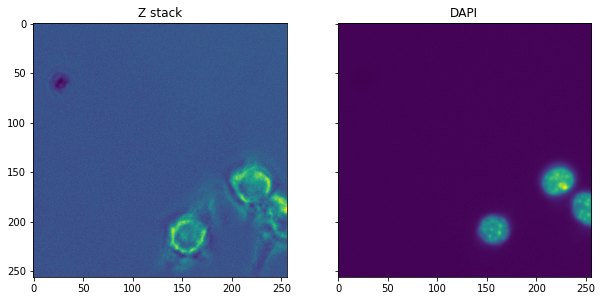

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_new[20, 20, :, :, 0])
ax[0].set_title('Z stack')

ax[1].imshow(y_new[20, :, :, 0])
ax[1].set_title('DAPI')
plt.show()

# Make mini file for testing

In [2]:
DATA_DIR = os.path.join(sys.path[0], 'scripts/recurr_gru/data/')
data_path = os.path.join(DATA_DIR, 'dapi_2.npz')

combined_npz = np.load(data_path)

X_data, y_data = combined_npz['X'][:,:, :128, :128, :], combined_npz['y'][:, :128, :128, :]
print(X_data.shape, y_data.shape)

file_name_save = os.path.join(DATA_DIR, 'dapi_2_1.npz')
np.savez(file_name_save, X=X_data, y=y_data)
print("saved!")

(756, 61, 128, 128, 1) (756, 128, 128, 1)
saved!


In [3]:
X_data, y_data = combined_npz['X'][:,:, 128:, 128:, :], combined_npz['y'][:, 128:, 128:, :]
print(X_data.shape, y_data.shape)

file_name_save = os.path.join(DATA_DIR, 'dapi_2_2.npz')
np.savez(file_name_save, X=X_data, y=y_data)
print("saved!")

(756, 61, 128, 128, 1) (756, 128, 128, 1)
saved!
